# **Build a CNN on MNIST Dataset**

# 0. Set Up

For this tutorial, we will be using ``numpy`` to generate data and all operations, ``matplotlib`` to render and plot images and of course ``nets`` for ``Tensor`` operations and computational graph creation. We will set the ``SEED`` for random numbers from ``numpy``, so each time we reload the notebook the results will be the same as numbers will be generated in the same way. Finally, we set an autoreload with ``%load_ext autoreload`` and ``%autoreload 2`` for debug mode purposes. This enable the notebook to reload the modules each time we run a cell, so it keeps everything up-to-date. More info [on StackOverflow](http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython).

Let's load the packages we need to run our tests:

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')
# Change the font ?
font = {'size'   : 15}
plt.rc('font', **font)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Let's fix the seed

SEED = 42
rd.seed(SEED)
np.random.seed(SEED)

# 1. Download the dataset

In [3]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

import nets
import nets.datasets as datasets

# IMPORTANT: normalize the data !
# 1. reshape from (data_length, 32, 32, 3) to (data_length, 32 * 32 * 3)
reshape = lambda x: x.reshape(-1, 784)
# 2. scale the data: data = (data - mean) / std
normalize = lambda x: (x - np.mean(x, axis=1, keepdims=True)) / np.std(x, axis=1, keepdims=True)
# 3. all together
transform = lambda x: normalize(reshape(x)).reshape(-1, 1, 28, 28)#.transpose(0, 3, 1, 2)

# Download the training and testing data
train_data, test_data = datasets.MNIST.splits(transform = transform)


train_data

Dataset MNIST(
   (data): Tensor(shape=(60000, 1, 28, 28), dtype=float64)
   (labels): Tensor(shape=(60000,), dtype=uint8)
)

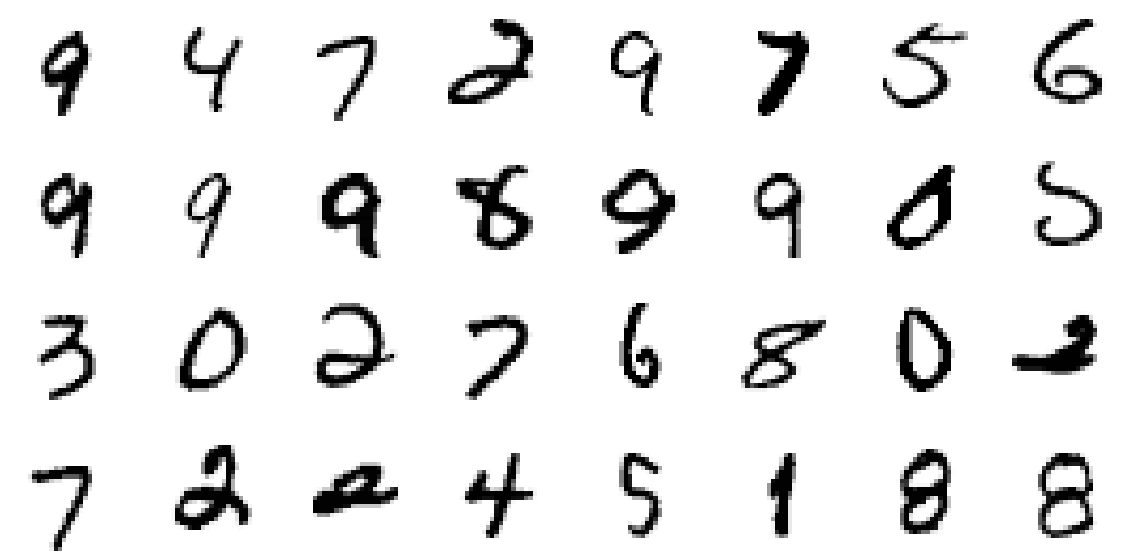

In [4]:
# CIFAR10 classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Configure the mosaic to display images
fig = plt.figure(figsize = (20, 10))
columns = 8
rows = 4

# Create the mosaic
for i in range(1, columns * rows + 1):
    # Choose randomly an image
    image_index = rd.randint(0, len(train_data))
    image, label = train_data[image_index]
    # Plot it
    fig.add_subplot(rows, columns, i)
    plt.imshow(image.numpy().reshape(28, 28))
    # Remove axis and display image's label
    # plt.title(classes[label.data])
    plt.axis('off')
    
# Render
plt.show()

# 2. Load the data

In [5]:
from nets.data import Iterator

BATCH_SIZE = 64

iterator = Iterator(train_data, 
                    batch_size = BATCH_SIZE, 
                    shuffle = True)

In [20]:
import nets.nn as nn

class Classifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        # Input batch shape: [batch_size, num_channel, height, width]
        #         for MNIST: [batch_size,       1    ,   28  ,  28  ]
        
        self.conv = nn.Conv2d(1, 1, (3, 3), stride=1, pad=0)
        # Output shape: [batch_size, num_channel, height - 2, width - 2]
        #           ie: [batch_size,        1   ,      26   ,     26   ]
        
        self.pool = nn.MaxPool2d((2, 2), stride=2, pad=0)
        # Output shape: [batch_size, num_channel, height / 2, width / 2]
        #           ie: [batch_size,        1   ,      13   ,     13   ]

        
        # Input shape: [batch_size, num_channel * height * width]
        #          ie: [batch_size,              169            ]
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # Output shape: [batch_size, hidden_dim]
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        # Output shape: [batch_size, output_dim]

    def forward(self, inputs):
        # Convolution layer
        out = self.conv(inputs)
        # Decrease the dimensions
        out = self.pool(out)
        
        # Transition from 4-d tensor to 2-d tensor
        out = out.reshape(out.shape[0], -1)
        # From [batch_size, 1, H, W]
        #   to [batch_size, input_dim]
        
        # Classification layer
        out = nets.relu(self.layer1(out))
        out = nets.relu(self.layer2(out))
        
        # Prediction layer
        out = self.layer3(out)
        return out


model = Classifier(169, 100, 10)

# Let's check the architecture
model

D:\home\Arthur\Documents\Informatique\GitHub\nets\nets\nn\module\linear.py:33: DeprecationWarning: Call to deprecated function init_params (weights and biases will be initialized in another function soon. This method will be then deprecated in the next update).
  self.init_params()
D:\home\Arthur\Documents\Informatique\GitHub\nets\nets\nn\module\linear.py:33: DeprecationWarning: Call to deprecated function init_params (weights and biases will be initialized in another function soon. This method will be then deprecated in the next update).
  self.init_params()
D:\home\Arthur\Documents\Informatique\GitHub\nets\nets\nn\module\linear.py:33: DeprecationWarning: Call to deprecated function init_params (weights and biases will be initialized in another function soon. This method will be then deprecated in the next update).
  self.init_params()


Classifier(
   (conv): CNN(in_channels=1, out_channels=1, filter_size=(3, 3), stride=1, pad=0, bias=True)
   (pool): MaxPool(pool_size=(2, 2), stride=2, pad=0)
   (layer1): Linear(input_dim=169, output_dim=100, bias=True)
   (layer2): Linear(input_dim=100, output_dim=100, bias=True)
   (layer3): Linear(input_dim=100, output_dim=10, bias=True)
)

## 5.3. Criterion & Optimizer

In [21]:
from nets.optim import SGD
from nets.nn import CrossEntropyLoss, MSE
from nets.nn.utils import one_hot

# How much do we update the parameters
LEARNING_RATE = 0.01

optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

## 5.4. Training

In [22]:
import time
from nets.utils import progress_bar

# Training iterations
EPOCHS = 50

#Display the time during training
start = time.time()
# Record the loss
history = []

# Run the simulation EPOCHS times
for epoch in range(EPOCHS):
    
    # Keep track of the loss at each epoch
    epoch_loss = 0.0
    epoch_start = time.time()
    
    # Number of batches
    N  = len(iterator)

    # Predict for all batches
    for idx, batch in enumerate(iterator):
        
        # Gradients accumulates, therefore we need to set them to zero at each iteration
        model.zero_grad()
        
        # Get the data from the batch
        image, label = batch    
        # Run the forward pass on the model
        predictions = model(image)
        # Get how far are the predictions from the truth (aka gold labels)
        label = one_hot(label, 10).astype(int)
        loss = criterion(predictions, label)
        
        # Compute the gradient
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        # Record the loss for plotting
        epoch_loss += loss.item() # .item() is really important, it will free the memory from the computational graph
        # Let's plot a progress bar in the console
        progress_bar(idx, N, prefix="Training:", start_time=epoch_start)
    
    # Update the history of all previous loss
    history.append(epoch_loss / N)
    
    # Check the mean loss for this loop
    print(f"epoch: {epoch}/{EPOCHS} | loss: {epoch_loss / N:1.3E}")

# Duration of the total training loop
print('\ntime:', time.time() - start)

Training: 100% | [==================================================] | Time : 0m 32s | Done !
epoch: 0/50 | loss: 1.276E+00
Training: 100% | [==================================================] | Time : 0m 29s | Done !
epoch: 1/50 | loss: 5.492E-01
Training: 100% | [==================================================] | Time : 0m 28s | Done !
epoch: 2/50 | loss: 4.203E-01
Training: 100% | [==================================================] | Time : 0m 29s | Done !
epoch: 3/50 | loss: 3.659E-01
Training: 100% | [==================================================] | Time : 0m 23s | Done !
epoch: 4/50 | loss: 3.334E-01
Training: 100% | [==================================================] | Time : 0m 25s | Done !
epoch: 5/50 | loss: 3.102E-01
Training: 100% | [==================================================] | Time : 0m 31s | Done !
epoch: 6/50 | loss: 2.918E-01
Training: 100% | [==================================================] | Time : 0m 33s | Done !
epoch: 7/50 | loss: 2.765E-01


Text(0, 0.5, 'loss')

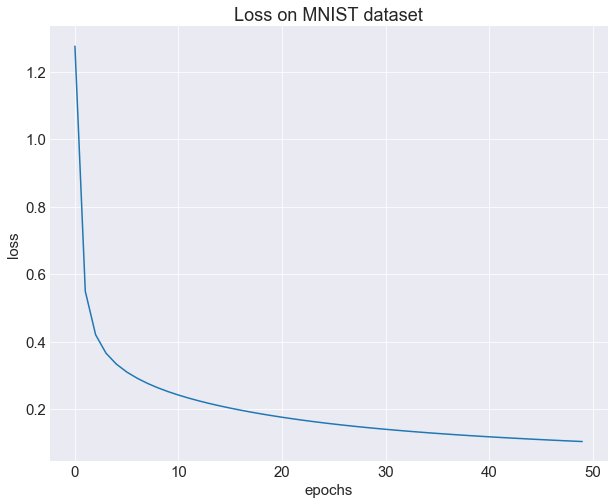

In [24]:
plt.plot(history)
plt.title("Loss on MNIST dataset")
plt.xlabel("epochs")
plt.ylabel("loss")